### Basic Chatbot with langgraph (Graph API)

In [1]:
from typing import Annotated 

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages


In [2]:
class State(TypedDict): 
    messages: Annotated[list,add_messages] #add_messages is a reducer that appends messages to the list rather than overwriting it 

graph_builder=StateGraph(State) 

In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.1-8b-instant")

In [6]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001FB34F2C290>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FB36054050>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001FB360565D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FB36055FD0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
def chatbot(state: State): 
    return {"messages":[llm.invoke(state['messages'])]}

In [9]:
graph_builder=StateGraph(State)
graph_builder.add_node("chat",chatbot)
graph_builder.add_edge(START,"chat")
graph_builder.add_edge("chat",END)
app=graph_builder.compile()

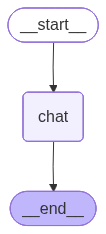

In [10]:
app

In [11]:
response=app.invoke({"messages":"Hi there!, I am Yeswanth"})

In [12]:
response["messages"][-1].content

"Hello Yeswanth, how are you today? It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [13]:
for event in app.stream({"messages":"Hello, how are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm doing well, thank you for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have. How can I assist you today?


### Chatbot with tools

In [14]:
from langchain_tavily import TavilySearch 

tool=TavilySearch(max_results=2) 
tool.invoke("What are the latest advancements in AI?")

{'query': 'What are the latest advancements in AI?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://ep.jhu.edu/news/advancements-in-ai-and-machine-learning/',
   'title': 'Advancements in AI and Machine Learning',
   'content': 'Advances in ML, natural language processing (NLP), and computer vision have enabled AI to perform ever-more complex tasks such as diagnosing',
   'score': 0.9992084,
   'raw_content': None},
  {'url': 'https://www.reddit.com/r/ArtificialInteligence/comments/1m5q2yr/what_are_some_latest_ai_developments/',
   'title': 'What are some latest AI developments? : r/ArtificialInteligence - Reddit',
   'content': "One of the most exciting recent breakthroughs is the advancement in reasoning models like OpenAI's o1 series, which demonstrates unprecedented",
   'score': 0.99913067,
   'raw_content': None}],
 'response_time': 0.73,
 'request_id': '2b7407a7-1ce0-4ac3-90ec-f0b81916e2b1'}

In [15]:
def multiply(a:int,b:int)->int: 
    """Multiple a and b
    Args:
        a (int): The first number
        b (int): The second number
    Returns:
        int: output int
    """
    return a*b
    

In [16]:
tools=[tool,multiply] 

In [17]:
llm_with_tools=llm.bind_tools(tools)

In [18]:
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001FB360565D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FB36055FD0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input sho

In [19]:
# State Graph with Tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition 

def tool_calling_llm(state:State): 
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder=StateGraph(State) 
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools)) 


builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

app_with_tools=builder.compile()

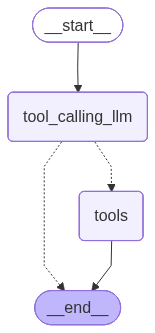

In [20]:
app_with_tools

In [24]:
app_with_tools.invoke({"messages":"Can you multiply 12 and 15 for me?"})

{'messages': [HumanMessage(content='Can you multiply 12 and 15 for me?', additional_kwargs={}, response_metadata={}, id='3bcf898d-1808-405b-b19e-157b067f864a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9z5z1p59b', 'function': {'arguments': '{"a":12,"b":15}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1804, 'total_tokens': 1823, 'completion_time': 0.030753144, 'completion_tokens_details': None, 'prompt_time': 0.130489634, 'prompt_tokens_details': None, 'queue_time': 0.050684988, 'total_time': 0.161242778}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1f1c-3ce3-71b2-aa02-630f174705c2-0', tool_calls=[{'name': 'multiply', 'args': {'a': 12, 'b': 15}, 'id': '9z5z1p59b', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_to

In [25]:
response=app_with_tools.invoke({"messages":"what is the latest research in artificial intelligence?"})
response["messages"][-1].content

'{"query": "latest research in artificial intelligence", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://quantumzeitgeist.com/artificial-recursivism-achieves-five-level-scale/", "title": "Recursivism Achieves Five-Level Scale For Self-Transforming Art With Artificial Intelligence - Quantum Zeitgeist", "score": 0.49128565, "published_date": "Mon, 26 Jan 2026 22:26:00 GMT", "content": "# Recursivism Achieves Five-Level Scale for Self-Transforming Art with Artificial Intelligence. Artificial intelligence, the researchers demonstrate, renders this recursive logic technically explicit through learning loops, parameter updates, and code-level self-modification, literalising structures previously implicit in artistic processes. This breakthrough reveals a deeper understanding of how art can evolve in the age of AI, moving beyond simple automation towards genuine co-creation and self-transformation, a paradigm shift with profound implications for artists

In [26]:
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is the latest research in artificial intelligence?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (ha80zqg3h)
 Call ID: ha80zqg3h
  Args:
    query: latest research in artificial intelligence
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest research in artificial intelligence", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://quantumzeitgeist.com/artificial-recursivism-achieves-five-level-scale/", "title": "Recursivism Achieves Five-Level Scale For Self-Transforming Art With Artificial Intelligence - Quantum Zeitgeist", "score": 0.49128565, "published_date": "Mon, 26 Jan 2026 22:26:00 GMT", "content": "# Recursivism Achieves Five-Level Scale for Self-Transforming Art with Artificial Intelligence. Artificial intellig

In [27]:
response=app_with_tools.invoke({"messages":"what is the product of 25 and 4?"})
response["messages"][-1].content

'100'

In [28]:
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is the product of 25 and 4?
================================== Ai Message ==================================
Tool Calls:
  multiply (bq55snre9)
 Call ID: bq55snre9
  Args:
    a: 25
    b: 4
================================= Tool Message =================================
Name: multiply

100


In [29]:
response=app_with_tools.invoke({"messages":"what is the product of 25 and 4 and multiply that by 3?"})
response["messages"][-1].content

'300'

In [30]:
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is the product of 25 and 4 and multiply that by 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (qapge4cxe)
 Call ID: qapge4cxe
  Args:
    a: 25
    b: 4
  multiply (1d0g89pz6)
 Call ID: 1d0g89pz6
  Args:
    a: 100
    b: 3
================================= Tool Message =================================
Name: multiply

100
================================= Tool Message =================================
Name: multiply

300


In [31]:
response=app_with_tools.invoke({"messages":"what is the recent ai news and multiply 5 by 3?"})
response["messages"][-1].content

'15'

In [32]:
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is the recent ai news and multiply 5 by 3?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (yy4b5rf6c)
 Call ID: yy4b5rf6c
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
  multiply (cgf80h1v5)
 Call ID: cgf80h1v5
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest News | Insights Powering AI-Driven Business ...", "content": "World of Work\n\nJanuary 27, 2026\n\n### How Formula E uses Google Cloud AI to meet net zero targets\n\nEnvironment & Sustainability\n\nJanuary 26, 2026\n\n### Controlling AI agent sprawl: The CIO’s guide to governanc

### React Agent Architecture

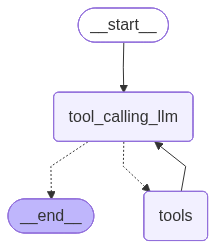

In [34]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition 

def tool_calling_llm(state:State): 
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder=StateGraph(State) 
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools)) 


builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

app_with_tools=builder.compile()
app_with_tools

In [35]:
response=app_with_tools.invoke({"messages":"what is the recent ai news and multiply 5 by 3?"})
response["messages"][-1].content
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is the recent ai news and multiply 5 by 3?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (z9f9k3ae5)
 Call ID: z9f9k3ae5
  Args:
    query: recent AI news
    topic: news
  multiply (7bt8w2j7r)
 Call ID: 7bt8w2j7r
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.gamingonlinux.com/2026/01/gog-now-using-ai-generated-images-on-their-store/", "title": "GOG now using AI generated images on their store - GamingOnLinux", "score": 0.9837225, "published_date": "Wed, 28 Jan 2026 15:16:04 GMT", "content": "More recent related news is that they're even looking to bring GOG Galaxy to Linux (finally!) with a new job opening - that link is quite relevant her

### Adding memory In Agentic Graph

In [37]:
response=app_with_tools.invoke({"messages":"Hello My Name is Vamshi"})
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

Hello My Name is Vamshi
================================== Ai Message ==================================

Hello, nice to meet you Vamshi. Is there anything I can help you with or would you like to chat?


In [38]:
response=app_with_tools.invoke({"messages":"What is my Name?"})
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

What is my Name?
================================== Ai Message ==================================

I don't know your name as I don't have any information about you.


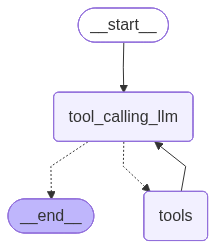

In [43]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition 
from langgraph.checkpoint.memory import MemorySaver

Memory=MemorySaver()
def tool_calling_llm(state:State): 
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder=StateGraph(State) 
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools)) 


builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

app_with_tools=builder.compile(checkpointer=Memory)
app_with_tools

In [44]:
config={"configurable":{"thread_id":"1"}}


response=app_with_tools.invoke({"messages":"Hi there!, I am Yeswanth"},config=config)

response

{'messages': [HumanMessage(content='Hi there!, I am Yeswanth', additional_kwargs={}, response_metadata={}, id='a57bc3b9-8c54-44df-80b6-6cc6f32cd7cf'),
  AIMessage(content='Nice to meet you, Yeswanth! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1801, 'total_tokens': 1818, 'completion_time': 0.018330571, 'completion_tokens_details': None, 'prompt_time': 0.11811925, 'prompt_tokens_details': None, 'queue_time': 0.06491601, 'total_time': 0.136449821}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1f27-3600-7093-a957-59e8a7f2f32c-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1801, 'output_tokens': 17, 'total_tokens': 1818})]}

In [45]:
response['messages'][-1].content

'Nice to meet you, Yeswanth! How can I assist you today?'

In [46]:
response=app_with_tools.invoke({"messages":"Hey whats my name?"},config=config)

response

{'messages': [HumanMessage(content='Hi there!, I am Yeswanth', additional_kwargs={}, response_metadata={}, id='a57bc3b9-8c54-44df-80b6-6cc6f32cd7cf'),
  AIMessage(content='Nice to meet you, Yeswanth! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1801, 'total_tokens': 1818, 'completion_time': 0.018330571, 'completion_tokens_details': None, 'prompt_time': 0.11811925, 'prompt_tokens_details': None, 'queue_time': 0.06491601, 'total_time': 0.136449821}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1f27-3600-7093-a957-59e8a7f2f32c-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1801, 'output_tokens': 17, 'total_tokens': 1818}),
  HumanMessage(content='Hey whats my name?', additional_kwargs={}, response_metadata={}, id='a90a604e-04e6-4eb8-9c

In [47]:
response['messages'][-1].content

'Your name is Yeswanth.'

In [48]:
response=app_with_tools.invoke({"messages":"Hey do you remember my name?"},config=config)

response['messages'][-1].content

'Yes, I remember your name is Yeswanth.'

### Streaming

In [49]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [50]:
def superbot(state:State): 
    return {"messages":[llm.invoke(state['messages'])]}

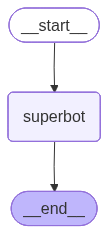

In [51]:
graph=StateGraph(State)

graph.add_node("superbot",superbot)
graph.add_edge(START,"superbot")
graph.add_edge("superbot",END)

graph_builder=graph.compile(checkpointer=memory)


graph_builder

In [52]:
config={"configurable":{"thread_id":"1"}}

graph_builder.invoke({"messages":"Hi there!, I am Yeswanth"},config=config)

{'messages': [HumanMessage(content='Hi there!, I am Yeswanth', additional_kwargs={}, response_metadata={}, id='c744d562-cded-4af2-8454-e7df0b2fce32'),
  AIMessage(content='Nice to meet you, Yeswanth. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 43, 'total_tokens': 60, 'completion_time': 0.027521779, 'completion_tokens_details': None, 'prompt_time': 0.002023949, 'prompt_tokens_details': None, 'queue_time': 0.05691874, 'total_time': 0.029545728}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1f2f-4466-7631-b24f-b2896776d89e-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 43, 'output_tokens': 17, 'total_tokens': 60})]}

### Streaming: stream, astream 

## modes = update, value 


In [53]:
config={"configurable":{"thread_id":"2"}} 
for chunk in graph_builder.stream({"messages":"Hello, do you know my name?"},config=config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="I'm happy to chat with you, but I don't have any information about your name. This is the start of our conversation, and I'm a large language model, I don't have personal knowledge about individual users. If you'd like to share your name, I'd be happy to use it in our conversation.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 43, 'total_tokens': 109, 'completion_time': 0.083604874, 'completion_tokens_details': None, 'prompt_time': 0.002547496, 'prompt_tokens_details': None, 'queue_time': 0.054012861, 'total_time': 0.08615237}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1f3a-b970-77d3-8c9f-fe22de82b6f0-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 43, 'output_tokens': 66, 'total_tokens': 109})]}}


In [54]:
config={"configurable":{"thread_id":"2"}} 
for chunk in graph_builder.stream({"messages":"Hello, do you know my name?"},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hello, do you know my name?', additional_kwargs={}, response_metadata={}, id='19edb741-43e9-4f3f-ad33-2a4b77bf964d'), AIMessage(content="I'm happy to chat with you, but I don't have any information about your name. This is the start of our conversation, and I'm a large language model, I don't have personal knowledge about individual users. If you'd like to share your name, I'd be happy to use it in our conversation.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 43, 'total_tokens': 109, 'completion_time': 0.083604874, 'completion_tokens_details': None, 'prompt_time': 0.002547496, 'prompt_tokens_details': None, 'queue_time': 0.054012861, 'total_time': 0.08615237}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1f3a-b970-77d3-8c9f-fe22de82b6f0-0', tool_call

In [55]:
config={"configurable":{"thread_id":"3"}} 
for chunk in graph_builder.stream({"messages":"Hello, my name is vamshi, I like cricket"},config=config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="Nice to meet you, Vamshi. Cricket is a fantastic sport, and I'm happy to chat with you about it. Are you a fan of a particular team or player? Do you enjoy playing cricket yourself or just watching it?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 47, 'total_tokens': 96, 'completion_time': 0.16109084, 'completion_tokens_details': None, 'prompt_time': 0.003015946, 'prompt_tokens_details': None, 'queue_time': 0.049208004, 'total_time': 0.164106786}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1f3c-6b8f-7771-ad1a-f46e02ac312e-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 47, 'output_tokens': 49, 'total_tokens': 96})]}}


In [56]:
for chunk in graph_builder.stream({"messages":"I also like badminton"},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hello, my name is vamshi, I like cricket', additional_kwargs={}, response_metadata={}, id='45ff86e0-ab7a-469f-8f8c-167addd1ee21'), AIMessage(content="Nice to meet you, Vamshi. Cricket is a fantastic sport, and I'm happy to chat with you about it. Are you a fan of a particular team or player? Do you enjoy playing cricket yourself or just watching it?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 47, 'total_tokens': 96, 'completion_time': 0.16109084, 'completion_tokens_details': None, 'prompt_time': 0.003015946, 'prompt_tokens_details': None, 'queue_time': 0.049208004, 'total_time': 0.164106786}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1f3c-6b8f-7771-ad1a-f46e02ac312e-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 47, 'out

In [58]:
config={"configurable":{"thread_id":"4"}} 
async for chunk in graph_builder.astream_events({"messages":"Hello, my name is vamshi, I like cricket"},config=config,stream_mode="updates"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hello, my name is vamshi, I like cricket'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019c1f3e-2d9c-7801-8ce3-a661c069af1c', 'metadata': {'thread_id': '4'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hello, my name is vamshi, I like cricket', additional_kwargs={}, response_metadata={}, id='6b0cd680-2639-430c-a11f-28ebe2870eb8')]}}, 'name': 'superbot', 'tags': ['graph:step:1'], 'run_id': '019c1f3e-2d9e-77f3-8822-f56241b389d5', 'metadata': {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'superbot', 'langgraph_triggers': ('branch:to:superbot',), 'langgraph_path': ('__pregel_pull', 'superbot'), 'langgraph_checkpoint_ns': 'superbot:785b7c9b-6a6d-0923-2e21-a043fb259118'}, 'parent_ids': ['019c1f3e-2d9c-7801-8ce3-a661c069af1c']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hello, my name is vamshi, I like cricket', addition